# Industry Skill Premium Analysis

**Author**: Mitchell Valdes  
**Date**: October 2025

This notebook provides a deep dive into industry-level patterns in capital accumulation, skill premiums, and factor shares.

## Objectives

1. **Industry Selection & Characteristics**: Examine heterogeneity across industries
2. **Skill Premium Dynamics**: Track wage premium evolution over time
3. **Capital-Labor Patterns**: Analyze capital deepening and composition shifts
4. **Cross-Industry Comparisons**: Identify commonalities and divergences
5. **Stylized Facts**: Document key empirical patterns for model validation

## Data Sources

- **Processed Data**: `data/proc/ind/*.csv` (from notebook 01)
- **Estimation Results**: `data/results/*.csv` (from Julia estimation)
- **Industry Names**: `data/industry_names.csv`

## Setup and Configuration

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
sys.path.insert(0, str(project_root))

import config

# Set plotting style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("✓ Libraries loaded")
print(f"  Project root: {project_root}")
print(f"  Data path: {config.PATH_PROC_IND}")

✓ Libraries loaded
  Project root: /Users/mitchv34/Work/industry_skill_premium
  Data path: /Users/mitchv34/Work/industry_skill_premium/data/proc/ind/


## Load Industry Names and Data

In [2]:
# Load industry names
industry_names = pd.read_csv(project_root / 'data' / 'industry_names.csv')
ind_dict = dict(zip(industry_names['BEA_Code'], industry_names['Description']))

print(f"✓ Loaded {len(industry_names)} industry names\n")
print("Sample industries:")
display(industry_names.head(10))

✓ Loaded 56 industry names

Sample industries:


,Description,BEA_Code
0,Farms,111CA
1,"Forestry, fishing, and related activities",113FF
2,Oil and gas extraction,211
3,"Mining, except oil and gas",212
4,Support activities for mining,213
5,Utilities,22
6,Construction,23
7,Food and beverage and tobacco products,311FT
8,Textile mills and textile product mills,313TT
9,Apparel and leather and allied products,315AL


In [3]:
# Load all industry data
proc_data_path = Path(config.PATH_PROC_IND)
industry_files = sorted(proc_data_path.glob('*.csv'))

# Load data into a dictionary
industry_data = {}
for f in industry_files:
    ind_code = f.stem
    df = pd.read_csv(f)
    df['industry_code'] = ind_code
    df['industry_name'] = ind_dict.get(ind_code, ind_code)
    industry_data[ind_code] = df

# Create combined dataframe
df_all = pd.concat(industry_data.values(), ignore_index=True)

print(f"✓ Loaded {len(industry_data)} industries")
print(f"  Total observations: {len(df_all):,}")
print(f"  Year range: {df_all['YEAR'].min()} - {df_all['YEAR'].max()}")
print(f"\nColumns available:")
for col in df_all.columns:
    print(f"  - {col}")

✓ Loaded 56 industries
  Total observations: 1,792
  Year range: 1987 - 2018

Columns available:
  - YEAR
  - L_SHARE
  - OUTPUT
  - K_STR
  - K_EQ
  - REL_P_EQ
  - DPR_ST
  - DPR_EQ
  - L_U
  - L_S
  - W_U
  - W_S
  - SKILL_PREMIUM
  - LABOR_INPUT_RATIO
  - industry_code
  - industry_name


## Industry Characteristics Overview

Let's examine the distribution of key variables across industries.

In [4]:
# Calculate industry-level summary statistics (most recent year)
latest_year = df_all['YEAR'].max()
df_latest = df_all[df_all['YEAR'] == latest_year].copy()

# Create summary table
summary_cols = ['K_EQ', 'K_STR', 'OUTPUT', 'SKILL_PREMIUM', 'L_SHARE']
df_summary = df_latest[['industry_name', 'industry_code'] + summary_cols].sort_values('OUTPUT', ascending=False)

print(f"Industry Characteristics in {latest_year}")
print("=" * 100)
print(f"\nTop 15 Industries by Output:\n")
display(df_summary.head(15))

Industry Characteristics in 2018

Top 15 Industries by Output:



,industry_name,industry_code,K_EQ,K_STR,OUTPUT,SKILL_PREMIUM,L_SHARE
1311,Real estate,531,186.244258,46845.386497,3108.989548,1.969234,0.067182
863,Wholesale trade,42,263.103347,276.741145,1877.862886,1.562316,0.459129
895,Retail trade,44RT,353.926230,997.082826,1694.513991,1.964000,0.596196
223,Construction,23,264.146000,73.673501,1487.310206,1.624392,0.797903
1407,"Miscellaneous professional, scientific, and te...",5412OP,168.586145,135.883148,1367.517246,2.071977,0.780912
1247,Insurance carriers and related activities,524,52.145933,124.593862,1108.015990,1.816749,0.507569
1631,Hospitals and nursing and residential care fac...,622HO,322.982555,803.156138,1064.396240,1.917221,0.856303
1599,Ambulatory health care services,621,200.515389,176.469452,1009.663062,2.272057,0.867736
1215,"Federal Reserve banks, credit intermediation, ...",521CI,563.503577,376.091578,923.330040,2.148728,0.400100
1503,Administrative and support services,561,118.887717,59.766276,917.530390,0.751089,0.820754


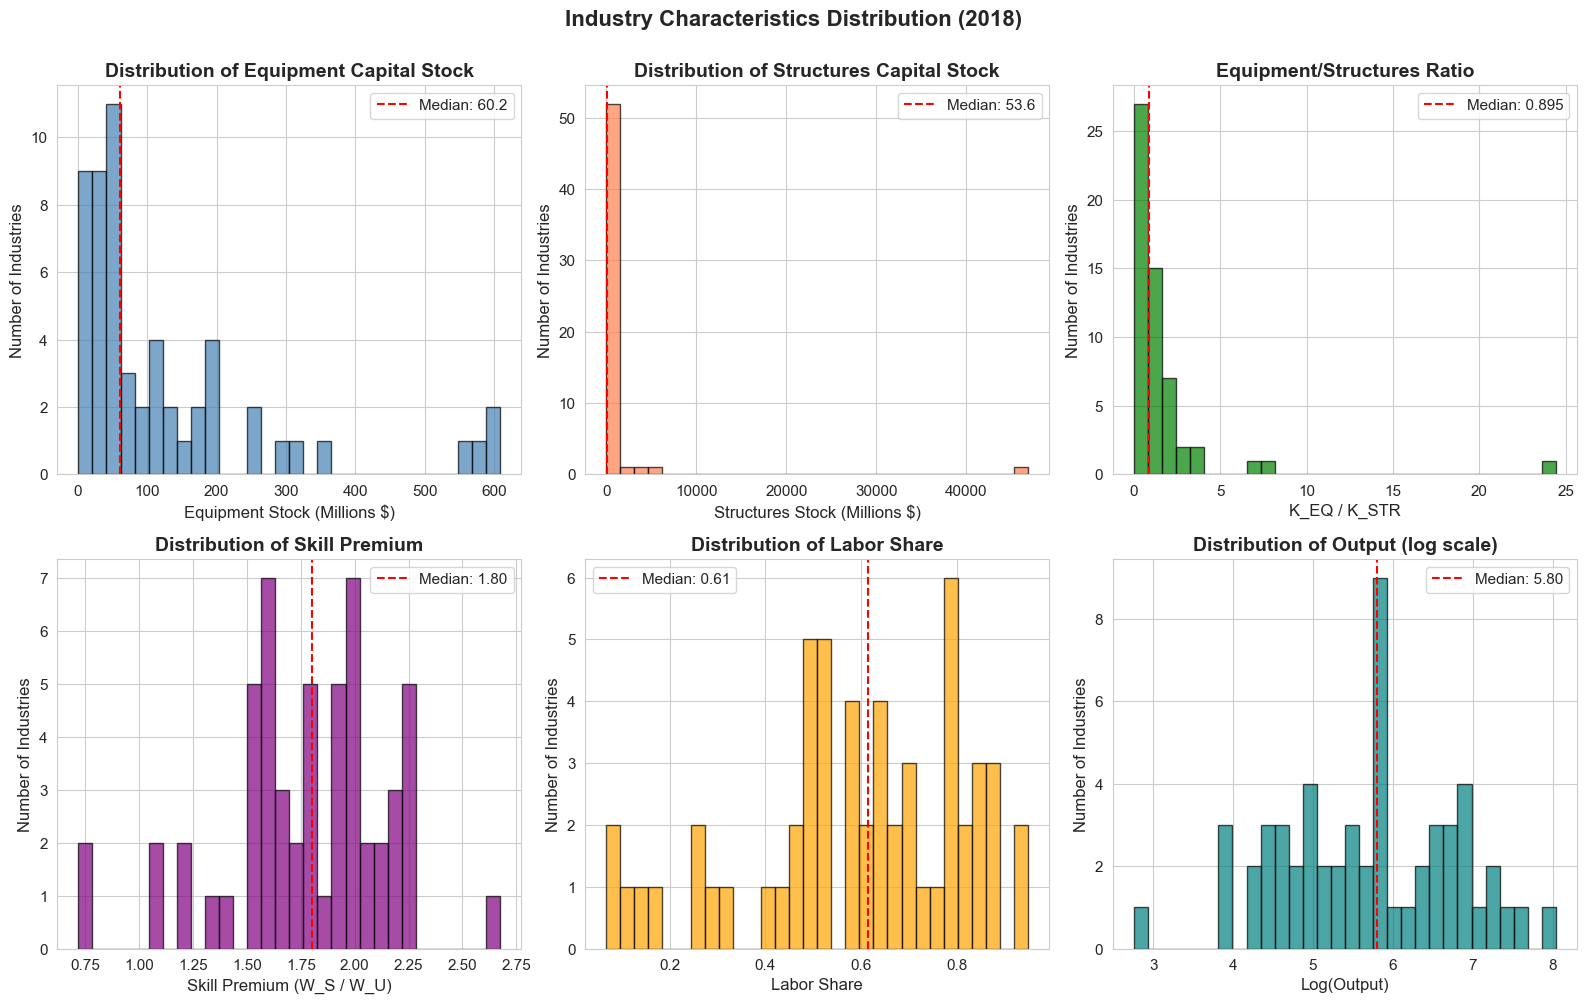

In [5]:
# Distribution plots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Capital Equipment
axes[0, 0].hist(df_latest['K_EQ'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribution of Equipment Capital Stock', fontweight='bold')
axes[0, 0].set_xlabel('Equipment Stock (Millions $)')
axes[0, 0].set_ylabel('Number of Industries')
axes[0, 0].axvline(df_latest['K_EQ'].median(), color='red', linestyle='--', 
                   label=f'Median: {df_latest["K_EQ"].median():.1f}')
axes[0, 0].legend()

# Capital Structures
axes[0, 1].hist(df_latest['K_STR'], bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribution of Structures Capital Stock', fontweight='bold')
axes[0, 1].set_xlabel('Structures Stock (Millions $)')
axes[0, 1].set_ylabel('Number of Industries')
axes[0, 1].axvline(df_latest['K_STR'].median(), color='red', linestyle='--',
                   label=f'Median: {df_latest["K_STR"].median():.1f}')
axes[0, 1].legend()

# Capital Ratio
df_latest['K_RATIO'] = df_latest['K_EQ'] / df_latest['K_STR']
axes[0, 2].hist(df_latest['K_RATIO'], bins=30, color='green', alpha=0.7, edgecolor='black')
axes[0, 2].set_title('Equipment/Structures Ratio', fontweight='bold')
axes[0, 2].set_xlabel('K_EQ / K_STR')
axes[0, 2].set_ylabel('Number of Industries')
axes[0, 2].axvline(df_latest['K_RATIO'].median(), color='red', linestyle='--',
                   label=f'Median: {df_latest["K_RATIO"].median():.3f}')
axes[0, 2].legend()

# Skill Premium
axes[1, 0].hist(df_latest['SKILL_PREMIUM'], bins=30, color='purple', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Distribution of Skill Premium', fontweight='bold')
axes[1, 0].set_xlabel('Skill Premium (W_S / W_U)')
axes[1, 0].set_ylabel('Number of Industries')
axes[1, 0].axvline(df_latest['SKILL_PREMIUM'].median(), color='red', linestyle='--',
                   label=f'Median: {df_latest["SKILL_PREMIUM"].median():.2f}')
axes[1, 0].legend()

# Labor Share
axes[1, 1].hist(df_latest['L_SHARE'], bins=30, color='orange', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Distribution of Labor Share', fontweight='bold')
axes[1, 1].set_xlabel('Labor Share')
axes[1, 1].set_ylabel('Number of Industries')
axes[1, 1].axvline(df_latest['L_SHARE'].median(), color='red', linestyle='--',
                   label=f'Median: {df_latest["L_SHARE"].median():.2f}')
axes[1, 1].legend()

# Output
axes[1, 2].hist(np.log(df_latest['OUTPUT']), bins=30, color='teal', alpha=0.7, edgecolor='black')
axes[1, 2].set_title('Distribution of Output (log scale)', fontweight='bold')
axes[1, 2].set_xlabel('Log(Output)')
axes[1, 2].set_ylabel('Number of Industries')
axes[1, 2].axvline(np.log(df_latest['OUTPUT']).median(), color='red', linestyle='--',
                   label=f'Median: {np.log(df_latest["OUTPUT"]).median():.2f}')
axes[1, 2].legend()

plt.suptitle(f'Industry Characteristics Distribution ({latest_year})', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## Skill Premium Dynamics

Analyze how skill premiums have evolved over time across industries.

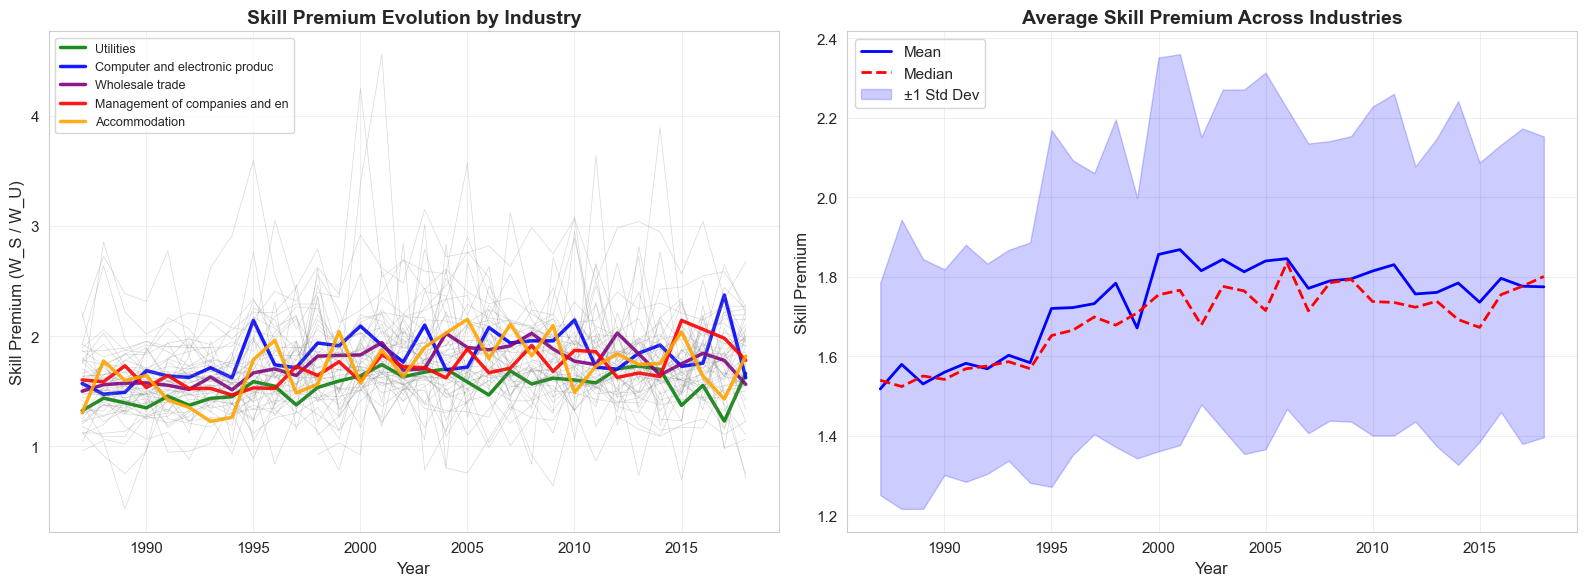

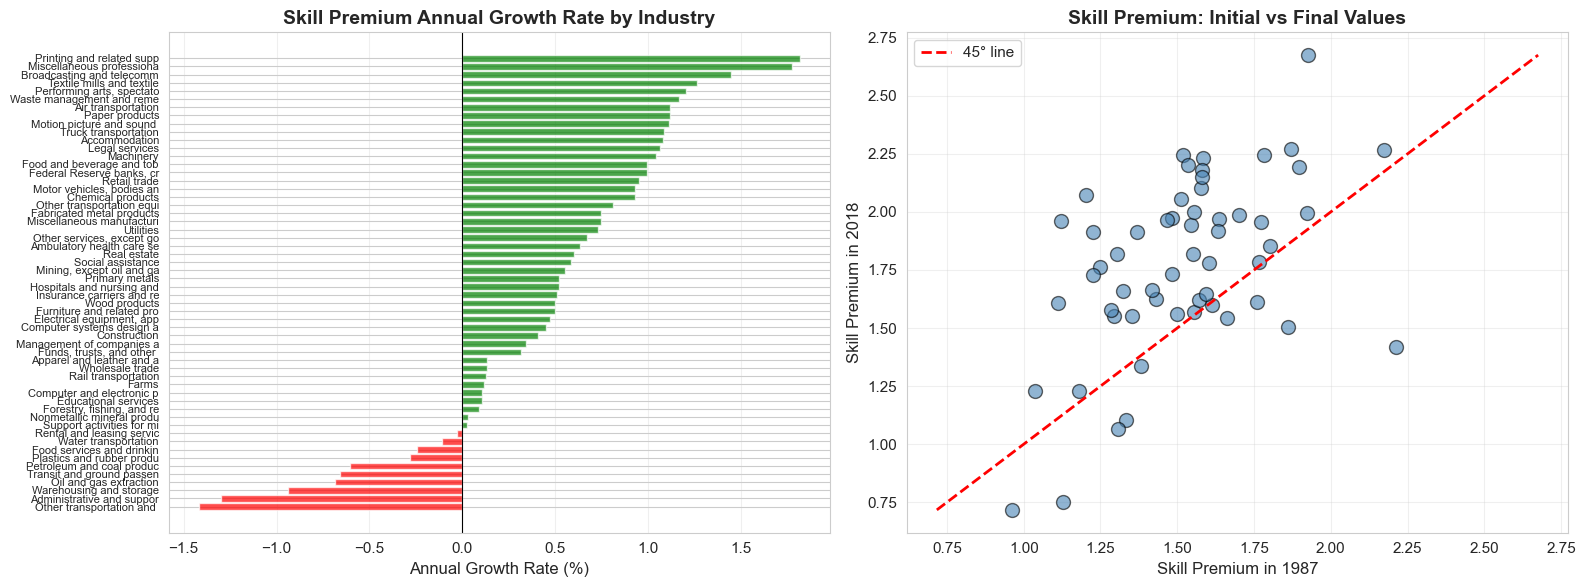

In [9]:
# Figure 1: (1x2) - Left: All industries with highlights, Right: Average skill premium
fig1, axes1 = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: All industries (gray), highlight a few
ax = axes1[0]
highlight_inds = ['334', '55', '22', '42', '721']  # Tech, Management, Utilities, Wholesale, Hotels
colors = {'334': 'blue', '55': 'red', '22': 'green', '42': 'purple', '721': 'orange'}
plotted_labels = set()

for ind_code in full_coverage_inds:
    df_ind = df_all[df_all['industry_code'] == ind_code].sort_values('YEAR')
    if ind_code in highlight_inds:
        label = ind_dict.get(ind_code, ind_code)[:30]
        # avoid duplicate legend entries
        if label in plotted_labels:
            ax.plot(df_ind['YEAR'], df_ind['SKILL_PREMIUM'],
                    linewidth=2.5, color=colors.get(ind_code, 'black'), alpha=0.9)
        else:
            ax.plot(df_ind['YEAR'], df_ind['SKILL_PREMIUM'],
                    linewidth=2.5, label=label, color=colors.get(ind_code, 'black'), alpha=0.9)
            plotted_labels.add(label)
    else:
        ax.plot(df_ind['YEAR'], df_ind['SKILL_PREMIUM'],
                linewidth=0.5, color='gray', alpha=0.3)

ax.set_title('Skill Premium Evolution by Industry', fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Skill Premium (W_S / W_U)')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

# Right plot: Average skill premium over time
ax = axes1[1]
avg_sp = df_all.groupby('YEAR')['SKILL_PREMIUM'].agg(['mean', 'median', 'std'])
ax.plot(avg_sp.index, avg_sp['mean'], linewidth=2, label='Mean', color='blue')
ax.plot(avg_sp.index, avg_sp['median'], linewidth=2, label='Median', color='red', linestyle='--')
ax.fill_between(avg_sp.index,
                avg_sp['mean'] - avg_sp['std'],
                avg_sp['mean'] + avg_sp['std'],
                alpha=0.2, color='blue', label='±1 Std Dev')
ax.set_title('Average Skill Premium Across Industries', fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Skill Premium')
ax.legend()
ax.grid(True, alpha=0.3)

fig1.tight_layout()
plt.show()

# Figure 2: (1x2) - Left: Annual growth rates (barh), Right: Initial vs Final scatter
fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Skill premium annual growth rates
ax = axes2[0]
growth_data = []
for ind_code in full_coverage_inds:
    df_ind = df_all[df_all['industry_code'] == ind_code].sort_values('YEAR')
    if len(df_ind) > 10:
        first_year_sp = df_ind.iloc[0]['SKILL_PREMIUM']
        last_year_sp = df_ind.iloc[-1]['SKILL_PREMIUM']
        years = df_ind.iloc[-1]['YEAR'] - df_ind.iloc[0]['YEAR']
        if first_year_sp > 0 and years > 0:
            annual_growth = ((last_year_sp / first_year_sp) ** (1 / years) - 1) * 100
            growth_data.append({
                'industry_code': ind_code,
                'industry_name': ind_dict.get(ind_code, ind_code),
                'annual_growth': annual_growth
            })

df_growth = pd.DataFrame(growth_data).sort_values('annual_growth').reset_index(drop=True)
ax.barh(range(len(df_growth)), df_growth['annual_growth'],
        color=['red' if x < 0 else 'green' for x in df_growth['annual_growth']], alpha=0.7)
ax.set_yticks(range(len(df_growth)))
ax.set_yticklabels([name[:25] for name in df_growth['industry_name']], fontsize=8)
ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('Annual Growth Rate (%)')
ax.set_title('Skill Premium Annual Growth Rate by Industry', fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Right plot: Scatter - Initial vs Final skill premium
ax = axes2[1]
scatter_data = []
for ind_code in full_coverage_inds:
    df_ind = df_all[df_all['industry_code'] == ind_code].sort_values('YEAR')
    if len(df_ind) > 10:
        scatter_data.append({
            'initial': df_ind.iloc[0]['SKILL_PREMIUM'],
            'final': df_ind.iloc[-1]['SKILL_PREMIUM'],
            'industry': ind_dict.get(ind_code, ind_code)[:20]
        })

df_scatter = pd.DataFrame(scatter_data)
ax.scatter(df_scatter['initial'], df_scatter['final'], s=100, alpha=0.6, c='steelblue', edgecolors='black')
min_val = min(df_scatter['initial'].min(), df_scatter['final'].min())
max_val = max(df_scatter['initial'].max(), df_scatter['final'].max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='45° line')
ax.set_xlabel(f'Skill Premium in {int(df_all["YEAR"].min())}')
ax.set_ylabel(f'Skill Premium in {int(df_all["YEAR"].max())}')
ax.set_title('Skill Premium: Initial vs Final Values', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

fig2.tight_layout()
plt.show()

## Capital-Labor Patterns

Examine capital deepening and the evolution of factor ratios.

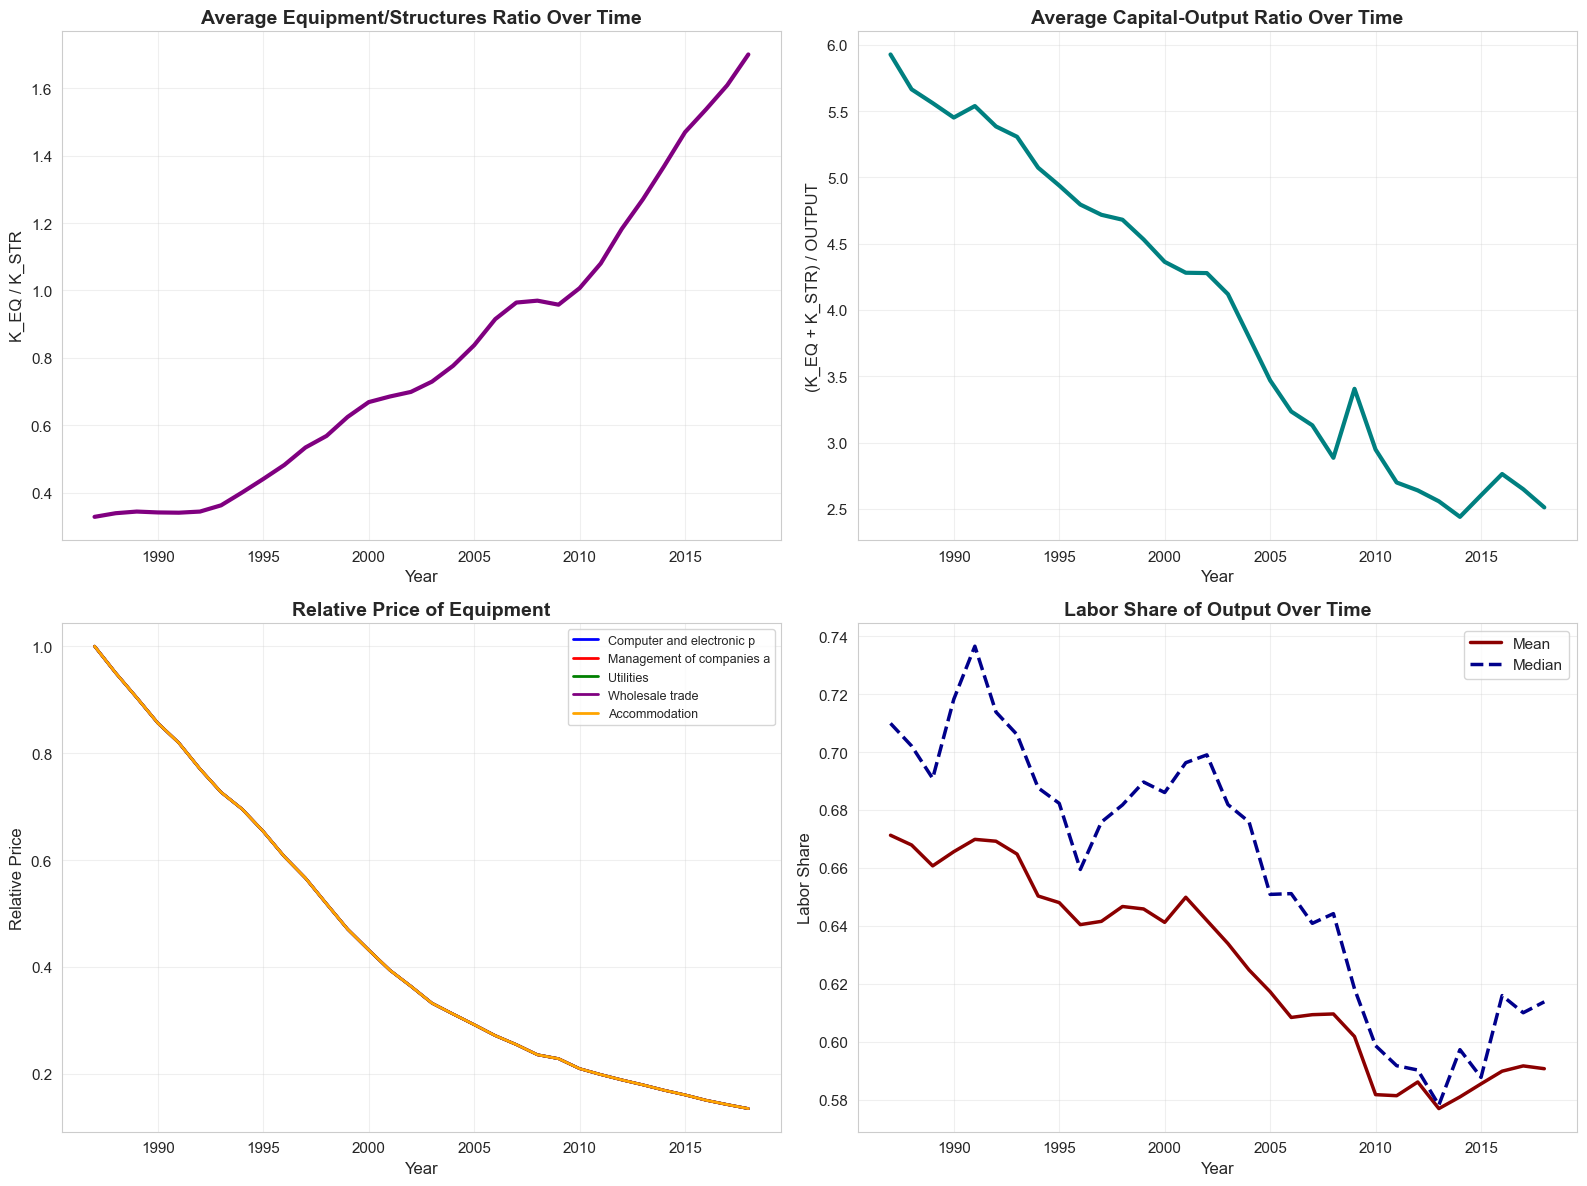

In [7]:
# Calculate capital-output and labor ratios
df_all['TOTAL_K'] = df_all['K_EQ'] + df_all['K_STR']
df_all['K_OUTPUT_RATIO'] = df_all['TOTAL_K'] / df_all['OUTPUT']
df_all['K_PER_WORKER'] = df_all['TOTAL_K'] / (df_all['L_S'] + df_all['L_U'])

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Equipment/Structures ratio over time
ax = axes[0, 0]
df_all['EQ_STR_RATIO'] = df_all['K_EQ'] / df_all['K_STR']
avg_ratio = df_all.groupby('YEAR')['EQ_STR_RATIO'].mean()
ax.plot(avg_ratio.index, avg_ratio.values, linewidth=3, color='purple')
ax.set_title('Average Equipment/Structures Ratio Over Time', fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('K_EQ / K_STR')
ax.grid(True, alpha=0.3)

# Plot 2: Capital-Output ratio trends
ax = axes[0, 1]
avg_k_output = df_all.groupby('YEAR')['K_OUTPUT_RATIO'].mean()
ax.plot(avg_k_output.index, avg_k_output.values, linewidth=3, color='teal')
ax.set_title('Average Capital-Output Ratio Over Time', fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('(K_EQ + K_STR) / OUTPUT')
ax.grid(True, alpha=0.3)

# Plot 3: Relative price of equipment
ax = axes[1, 0]
for ind_code in highlight_inds:
    df_ind = df_all[df_all['industry_code'] == ind_code]
    ax.plot(df_ind['YEAR'], df_ind['REL_P_EQ'], 
            linewidth=2, label=ind_dict.get(ind_code, ind_code)[:25],
            color=colors.get(ind_code, 'black'))
ax.set_title('Relative Price of Equipment', fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Relative Price')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 4: Labor share trends
ax = axes[1, 1]
avg_lshare = df_all.groupby('YEAR')['L_SHARE'].agg(['mean', 'median'])
ax.plot(avg_lshare.index, avg_lshare['mean'], linewidth=2.5, label='Mean', color='darkred')
ax.plot(avg_lshare.index, avg_lshare['median'], linewidth=2.5, label='Median', 
        color='darkblue', linestyle='--')
ax.set_title('Labor Share of Output Over Time', fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Labor Share')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Cross-Industry Correlations

Examine relationships between key variables.

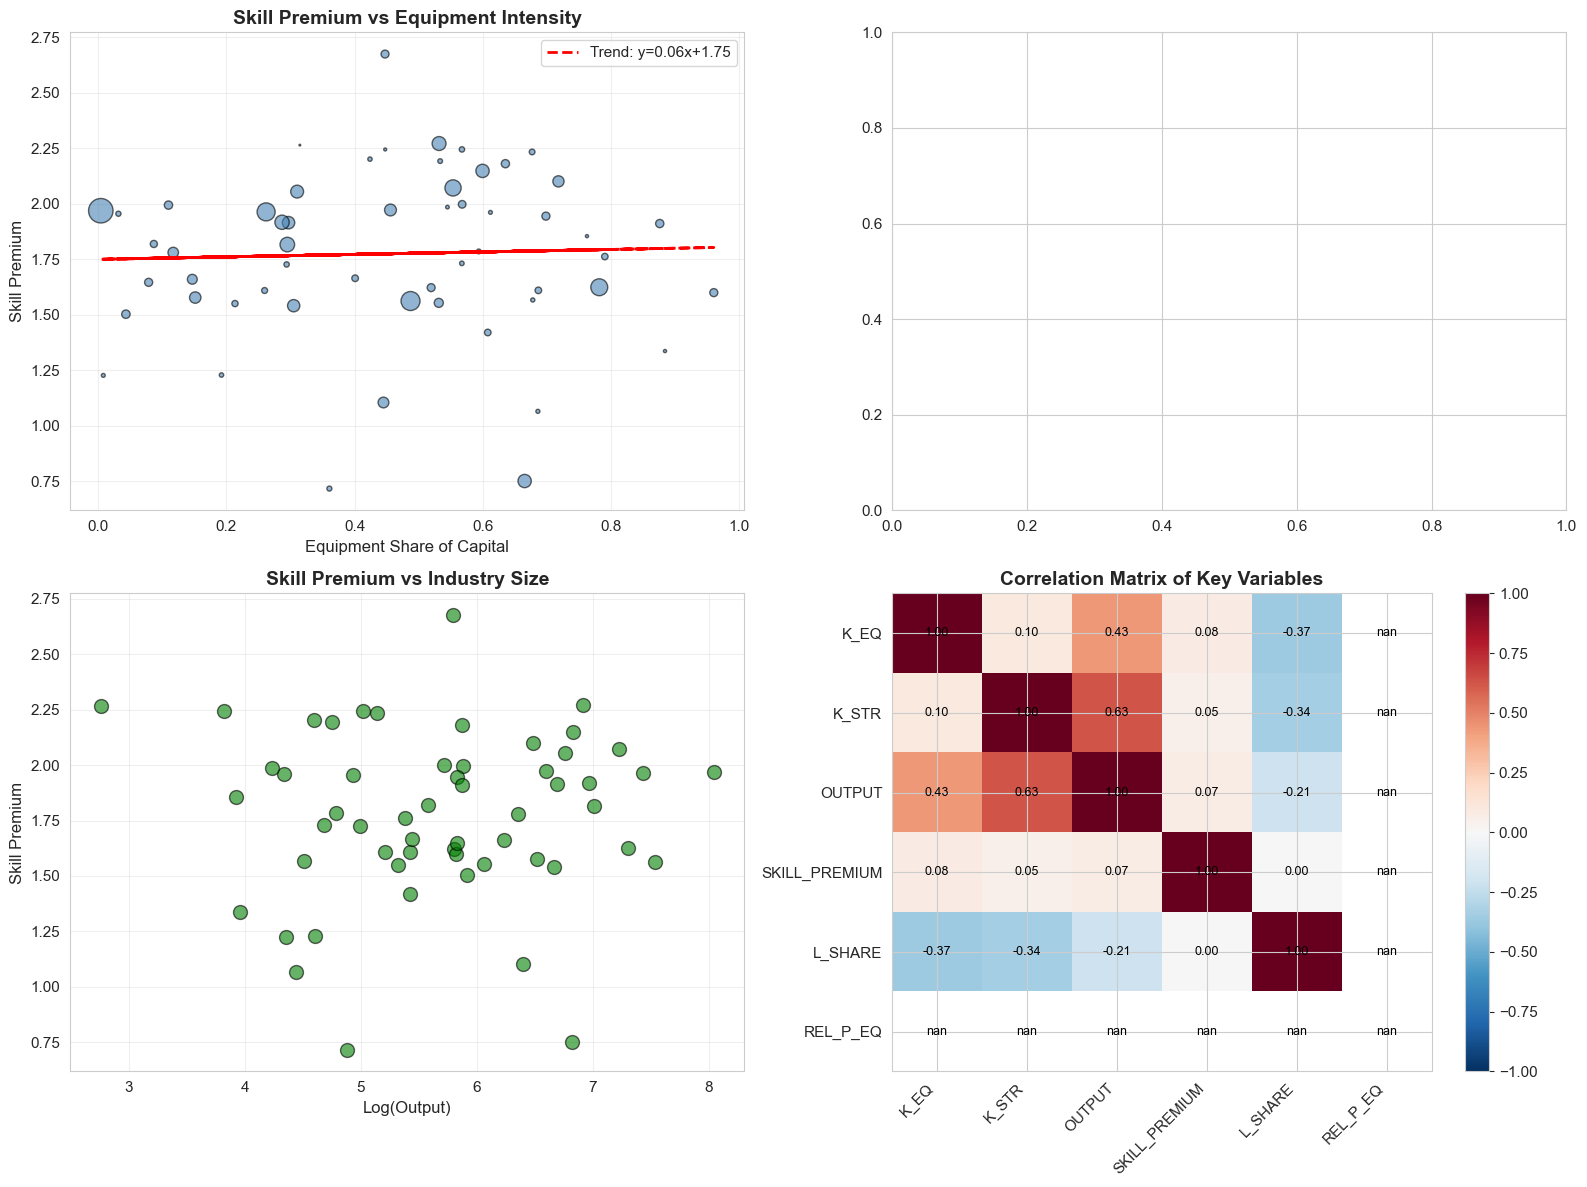

In [ ]:
# Create scatter plots for latest year
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Skill premium vs Equipment ratio
ax = axes[0, 0]
df_latest['EQ_RATIO'] = df_latest['K_EQ'] / (df_latest['K_EQ'] + df_latest['K_STR'])
ax.scatter(df_latest['EQ_RATIO'], df_latest['SKILL_PREMIUM'], 
           s=df_latest['OUTPUT']/10, alpha=0.6, c='steelblue', edgecolors='black')
ax.set_xlabel('Equipment Share of Capital')
ax.set_ylabel('Skill Premium')
ax.set_title('Skill Premium vs Equipment Intensity', fontweight='bold')
ax.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(df_latest['EQ_RATIO'], df_latest['SKILL_PREMIUM'], 1)
p = np.poly1d(z)
ax.plot(df_latest['EQ_RATIO'], p(df_latest['EQ_RATIO']), 
        "r--", linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
ax.legend()

# Plot 2: Labor share vs Capital intensity
ax = axes[0, 1]
ax.scatter(df_latest['K_OUTPUT_RATIO'], df_latest['L_SHARE'], 
           s=df_latest['OUTPUT']/10, alpha=0.6, c='coral', edgecolors='black')
ax.set_xlabel('Capital-Output Ratio')
ax.set_ylabel('Labor Share')
ax.set_title('Labor Share vs Capital Intensity', fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 3: Skill premium vs Output (log scale)
ax = axes[1, 0]
ax.scatter(np.log(df_latest['OUTPUT']), df_latest['SKILL_PREMIUM'], 
           s=100, alpha=0.6, c='green', edgecolors='black')
ax.set_xlabel('Log(Output)')
ax.set_ylabel('Skill Premium')
ax.set_title('Skill Premium vs Industry Size', fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 4: Correlation heatmap
ax = axes[1, 1]
corr_vars = ['K_EQ', 'K_STR', 'OUTPUT', 'SKILL_PREMIUM', 'L_SHARE', 'REL_P_EQ']
corr_matrix = df_latest[corr_vars].corr()
im = ax.imshow(corr_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
ax.set_xticks(range(len(corr_vars)))
ax.set_yticks(range(len(corr_vars)))
ax.set_xticklabels(corr_vars, rotation=45, ha='right')
ax.set_yticklabels(corr_vars)
ax.set_title('Correlation Matrix of Key Variables', fontweight='bold')

# Add correlation values
for i in range(len(corr_vars)):
    for j in range(len(corr_vars)):
        text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=9)

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

## Industry Deep Dive: Selected Cases

Examine specific industries in detail.

In [ ]:
# Select diverse industries for detailed analysis
case_studies = {
    '334': 'Computer and electronic products',
    '55': 'Management of companies',
    '22': 'Utilities',
    '42': 'Wholesale trade',
    '721': 'Accommodation',
    '3361MV': 'Motor vehicles'
}

fig, axes = plt.subplots(3, 2, figsize=(16, 16))
axes = axes.flatten()

for idx, (ind_code, name) in enumerate(case_studies.items()):
    if ind_code in industry_data:
        df_ind = industry_data[ind_code]
        ax = axes[idx]
        
        # Create dual axis plot
        ax2 = ax.twinx()
        
        # Plot skill premium
        line1 = ax.plot(df_ind['YEAR'], df_ind['SKILL_PREMIUM'], 
                       linewidth=3, color='darkblue', label='Skill Premium', marker='o')
        
        # Plot equipment ratio
        df_ind['EQ_SHARE'] = df_ind['K_EQ'] / (df_ind['K_EQ'] + df_ind['K_STR'])
        line2 = ax2.plot(df_ind['YEAR'], df_ind['EQ_SHARE'], 
                        linewidth=3, color='darkred', label='Equipment Share', 
                        marker='s', linestyle='--')
        
        ax.set_xlabel('Year', fontweight='bold')
        ax.set_ylabel('Skill Premium', color='darkblue', fontweight='bold')
        ax2.set_ylabel('Equipment Share', color='darkred', fontweight='bold')
        ax.tick_params(axis='y', labelcolor='darkblue')
        ax2.tick_params(axis='y', labelcolor='darkred')
        
        # Title with industry name
        title = f'{name}\n({ind_code})'
        ax.set_title(title, fontweight='bold', fontsize=11)
        
        # Combined legend
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax.legend(lines, labels, loc='best', fontsize=9)
        
        ax.grid(True, alpha=0.3)

plt.suptitle('Industry Case Studies: Skill Premium vs Equipment Share', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## Stylized Facts Summary

Document key empirical patterns for model validation.

In [ ]:
print("=" * 100)
print("STYLIZED FACTS: INDUSTRY SKILL PREMIUM AND CAPITAL DYNAMICS")
print("=" * 100)

# Fact 1: Skill premium trends
sp_growth = df_growth['annual_growth'].describe()
print(f"\n1. SKILL PREMIUM DYNAMICS")
print(f"   - Average annual growth: {sp_growth['mean']:.3f}%")
print(f"   - Median annual growth: {sp_growth['50%']:.3f}%")
print(f"   - Range: [{sp_growth['min']:.3f}%, {sp_growth['max']:.3f}%]")
print(f"   - Industries with declining premium: {(df_growth['annual_growth'] < 0).sum()} out of {len(df_growth)}")

# Fact 2: Equipment intensity
eq_share_start = df_all[df_all['YEAR'] == df_all['YEAR'].min()]['EQ_STR_RATIO'].mean()
eq_share_end = df_all[df_all['YEAR'] == df_all['YEAR'].max()]['EQ_STR_RATIO'].mean()
print(f"\n2. CAPITAL COMPOSITION")
print(f"   - Average K_EQ/K_STR ratio (start): {eq_share_start:.4f}")
print(f"   - Average K_EQ/K_STR ratio (end): {eq_share_end:.4f}")
print(f"   - Change: {(eq_share_end/eq_share_start - 1)*100:.2f}%")

# Fact 3: Labor share
lshare_stats = df_all.groupby('YEAR')['L_SHARE'].mean()
print(f"\n3. LABOR SHARE")
print(f"   - Average labor share (start): {lshare_stats.iloc[0]:.3f}")
print(f"   - Average labor share (end): {lshare_stats.iloc[-1]:.3f}")
print(f"   - Change: {(lshare_stats.iloc[-1] - lshare_stats.iloc[0]):.4f}")

# Fact 4: Cross-sectional variation
print(f"\n4. CROSS-INDUSTRY VARIATION (latest year)")
print(f"   - Skill premium CV: {df_latest['SKILL_PREMIUM'].std() / df_latest['SKILL_PREMIUM'].mean():.3f}")
print(f"   - Equipment share CV: {df_latest['EQ_RATIO'].std() / df_latest['EQ_RATIO'].mean():.3f}")
print(f"   - Labor share CV: {df_latest['L_SHARE'].std() / df_latest['L_SHARE'].mean():.3f}")

# Fact 5: Correlations
print(f"\n5. KEY CORRELATIONS (latest year)")
print(f"   - Skill Premium vs Equipment Share: {df_latest[['SKILL_PREMIUM', 'EQ_RATIO']].corr().iloc[0,1]:.3f}")
print(f"   - Labor Share vs Capital Intensity: {df_latest[['L_SHARE', 'K_OUTPUT_RATIO']].corr().iloc[0,1]:.3f}")
print(f"   - Skill Premium vs Output (log): {pd.concat([df_latest['SKILL_PREMIUM'], np.log(df_latest['OUTPUT'])], axis=1).corr().iloc[0,1]:.3f}")

print(f"\n" + "=" * 100)

## Export Analysis Results

Save summary statistics for use in manuscript.

In [ ]:
# Save summary statistics
output_dir = project_root / 'data' / 'analysis'
output_dir.mkdir(exist_ok=True)

# Summary table
df_summary.to_csv(output_dir / 'industry_summary_latest.csv', index=False)
print(f"✓ Saved: {output_dir / 'industry_summary_latest.csv'}")

# Growth rates
df_growth.to_csv(output_dir / 'skill_premium_growth.csv', index=False)
print(f"✓ Saved: {output_dir / 'skill_premium_growth.csv'}")

# Time series aggregates
df_timeseries = df_all.groupby('YEAR').agg({
    'SKILL_PREMIUM': ['mean', 'median', 'std'],
    'L_SHARE': ['mean', 'median', 'std'],
    'EQ_STR_RATIO': ['mean', 'median', 'std'],
    'K_OUTPUT_RATIO': ['mean', 'median', 'std']
}).reset_index()
df_timeseries.to_csv(output_dir / 'aggregate_timeseries.csv', index=False)
print(f"✓ Saved: {output_dir / 'aggregate_timeseries.csv'}")

print("\n✅ Analysis complete!")

---

## Summary

This notebook explored industry-level patterns in:

1. **Skill Premium Dynamics**: Most industries show rising skill premiums, but with substantial heterogeneity
2. **Capital Composition**: Equipment-to-structures ratios have evolved differently across industries
3. **Labor Share Trends**: Labor shares show both common trends and industry-specific patterns
4. **Cross-Industry Relationships**: Positive correlation between equipment intensity and skill premiums

### Next Steps

- **Notebook 03**: Model estimation and parameter recovery
- **Manuscript**: Use stylized facts to motivate model specification
- **Further Analysis**: Industry-specific counterfactuals and decompositions